In [ ]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v6 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [912 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bioni

# All Imports

In [ ]:

from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt
import gfootball 
import math
import os
import utils


## Testing that the observations are right 

In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
new_observation,reward,done,info = env.step(5)
new_observation,reward,done,info = env.step(5)
new_observation,reward,done,info = env.step(5)
print(new_observation)
len(new_observation)

[ 5.9748744e-03 -3.4153327e-09  5.9163757e-03 -4.0305520e-10
  9.9810743e-01 -2.2659341e-10 -6.5200469e-03  6.1910177e-10
  2.0000000e-02 -0.0000000e+00  1.1053141e-01 -0.0000000e+00
  0.0000000e+00 -2.2479375e-03  1.0000000e+00  0.0000000e+00
  0.0000000e+00]


17

# Create Deep Q Network 

In [ ]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork,self).__init__()

    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
    #x=F.relu(self.fc3(x))
    return actions

# Create Agent class - Replay Buffer - choose action function

In [ ]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 10000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    #self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=262, fc2_dims=262)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions 
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
     
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    


    batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
    batch_index = np.arange(self.batch_size , dtype=np.int32)

    state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch] 
  
    q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] 
    q_next = self.Q_eval.forward(new_state_batch)

    q_next[terminal_batch] = 0.0
    q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min


---Avg reward last 10:  -3.3340332256685237 Avg score last 10:  0.2 Avg steps 75.8 episode= 10 ---
---Avg reward last 10:  -0.06336234243251289 Avg score last 10:  0.3 Avg steps 82.4 episode= 20 ---
---Avg reward last 10:  1.0372030697950454 Avg score last 10:  0.6 Avg steps 97.5 episode= 30 ---
---Avg reward last 10:  0.4812252463314003 Avg score last 10:  0.5 Avg steps 101.0 episode= 40 ---
---Avg reward last 10:  1.0434367127160011 Avg score last 10:  0.6 Avg steps 95.7 episode= 50 ---
Last 50 episodes avg score 0.44


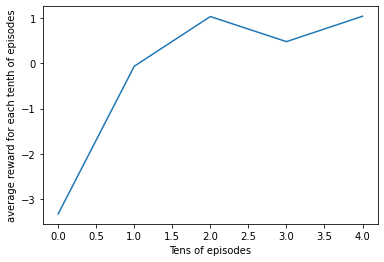

---Avg reward last 10:  0.5457193714223425 Avg score last 10:  0.5 Avg steps 89.5 episode= 60 ---
---Avg reward last 10:  -0.2271140407867144 Avg score last 10:  0.2 Avg steps 94.6 episode= 70 ---
---Avg reward last 10:  1.016733612866435 Avg score last 10:  0.6 Avg steps 92.2 episode= 80 ---
---Avg reward last 10:  0.6852712891654765 Avg score last 10:  0.6 Avg steps 87.5 episode= 90 ---
---Avg reward last 10:  1.2411748501353765 Avg score last 10:  0.7 Avg steps 99.4 episode= 100 ---


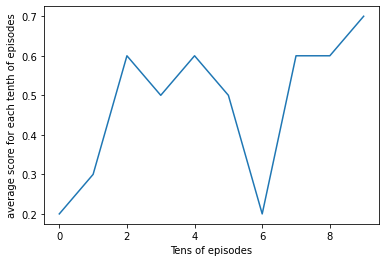

Last 50 episodes avg score 0.52


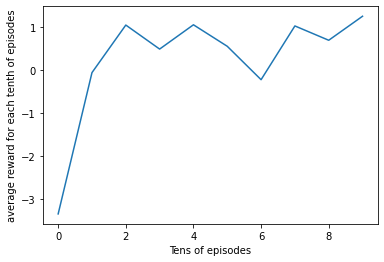

---Avg reward last 10:  0.9833100360377246 Avg score last 10:  0.7 Avg steps 95.8 episode= 110 ---
---Avg reward last 10:  0.7092939556842118 Avg score last 10:  0.7 Avg steps 100.9 episode= 120 ---
---Avg reward last 10:  1.0803964421232923 Avg score last 10:  0.4 Avg steps 108.3 episode= 130 ---
---Avg reward last 10:  1.2986068358269207 Avg score last 10:  0.7 Avg steps 98.9 episode= 140 ---
---Avg reward last 10:  -0.2248104012369454 Avg score last 10:  0.7 Avg steps 99.1 episode= 150 ---
Last 50 episodes avg score 0.64


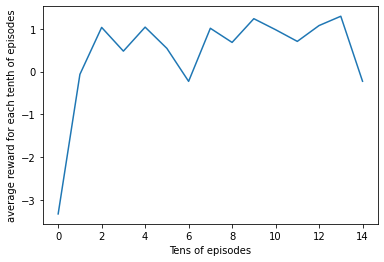

---Avg reward last 10:  0.0875020004072308 Avg score last 10:  0.5 Avg steps 90.7 episode= 160 ---
---Avg reward last 10:  0.22852626768899031 Avg score last 10:  0.6 Avg steps 80.6 episode= 170 ---
---Avg reward last 10:  1.0274359886899092 Avg score last 10:  0.7 Avg steps 87.6 episode= 180 ---
---Avg reward last 10:  0.9807509442348898 Avg score last 10:  0.7 Avg steps 92.8 episode= 190 ---
---Avg reward last 10:  1.1342223293166993 Avg score last 10:  0.7 Avg steps 92.0 episode= 200 ---


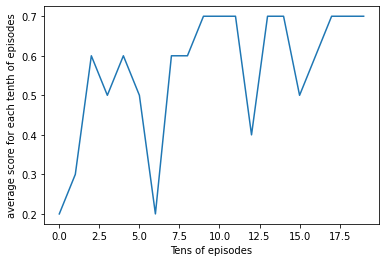

Last 50 episodes avg score 0.64


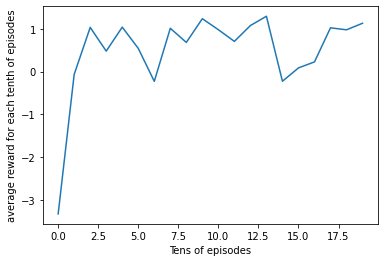

---Avg reward last 10:  0.2890182593100848 Avg score last 10:  0.5 Avg steps 81.7 episode= 210 ---
---Avg reward last 10:  1.0492016064433718 Avg score last 10:  0.7 Avg steps 95.4 episode= 220 ---
---Avg reward last 10:  0.9538342200101033 Avg score last 10:  0.6 Avg steps 93.4 episode= 230 ---
---Avg reward last 10:  1.05795082102092 Avg score last 10:  0.7 Avg steps 94.6 episode= 240 ---
---Avg reward last 10:  1.4503078494413422 Avg score last 10:  0.7 Avg steps 88.2 episode= 250 ---
Last 50 episodes avg score 0.64


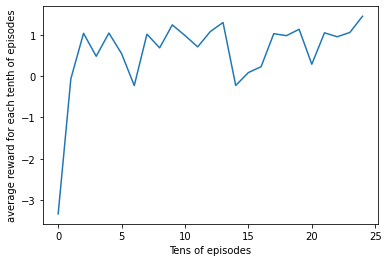

---Avg reward last 10:  1.3805662401064775 Avg score last 10:  0.9 Avg steps 97.1 episode= 260 ---
END OF TRAINING
Last 50 episodes avg score 0.7


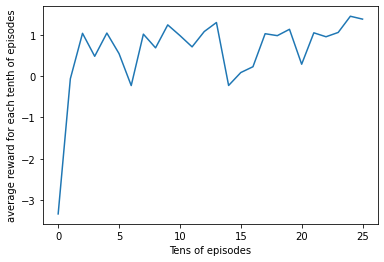

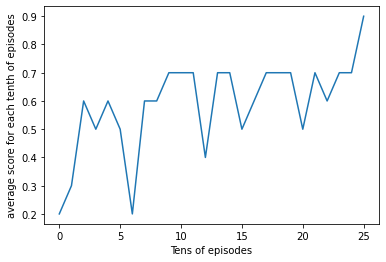

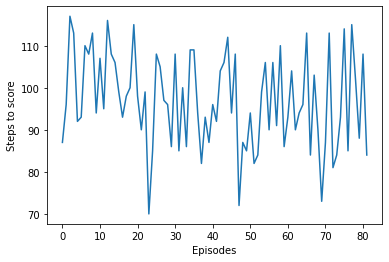

FINAL SCORE PERCENTAGE 0.7


In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 17 states 


#CUSTOMIZE ACTION LIST 
Action_list=[4,5,6,12,13,14,15,17,18]

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.0011 ,input_dims= [17], n_actions = len(Action_list) )


scores,ep_history =[],[]

steps=0
terminal =0 
episode =0
shout =0

num_of_eps = 20001
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
avg_score_list = []
avg_rew_list =[]
steal = []
steps_to_goal = []
for i in range(num_of_eps) : 
  score =0 
  done=False 
  eps_rew=0
  observation =env.reset()

  act =0 #first action will be a move to the ball 
  shout=0 #Agent can shout one time in each episode
  timer=0 #If opponents stole the ball for at least 4 steps epiode stops
  forward=0 #First time Agent passes the opponent
  sprint=0 # First time agent spint 
  dribble =0 # First time dribble before the opponent
  fault =0
  checkpoint_reward=[1,1,1,1,1]
  steps=0
  reward =0 

  while not done:

    #CUSTOMIZE ACTIONS HERE 
    if(act ==0 ): # first action is a move to the ball
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1

    action = agent.choose_action(observation) # from 1-9s which is index to action list

    while((observation[0] > observation[4] +0.02)  and (Action_list[action]==17 or Action_list[action]==18 )): # if agent pass the opponent dont dribble again
      action = agent.choose_action(observation)
    while((observation[0]<0.65)  and (Action_list[action]==12)): #Agent cannot shout outside of the box
      action = agent.choose_action(observation)

    if(shout==0):   #if agent shouts dont do shout again 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12): #if agent shouts , shout =1 
        shout=1
    else:
      new_observation,reward,done,info = env.step(0)
      action=0 

# END OF CUSTOM ACTIONS

#CUSTOM REWARDS - Reward Function-------------------------------
    if(done ==1 and reward ==1): #if agent scores , wins +50
      #print("goal","episode",i,"step=",steps)
      reward += 60
      steps_to_goal.append(steps)
   
    if(done ==1 and reward == 0): # if opponent shouts ball out -15 , if agent shouts bal out -5 
      if(shout ==1 ):
        reward = reward - 10
        terminal =0
      else:
        if(observation[9] <0.4 or observation[9] >-0.4 ):
          fault =1
          
        else:
          reward = reward -20 
          terminal =0

      terminal= terminal +1

    if(observation[16]==1 ):  # If ball is stolen for at least 4 steps , episode ends
      #print("antipalos")
      timer=timer+1
      reward = reward - 20
      if(timer == 2 ):
        reward = reward - 30
        terminal =0
      if (timer>2 and timer <  4 ):
        reward = reward - 40 
        
      if (timer>4 and timer <6 ):
        reward = reward - 50
        done =1
   

    if(observation[8]< 0.0 ):  #If ball goes on the other side of the field , episode ends
      reward = reward-35
      done =1 

    if(observation[9]>0.35 or observation[9]<-0.35):  #Ball is outside field boundaries
      reward = reward - 35
      done = 1

    #----------------
    if(observation[14]== 0): #If agent hasnt the ball possesion
      reward =reward-5

    if ((observation[8] > observation[0] + 0.05) and (observation[9] - observation[1] <=0.03) or(observation[9] - observation[1] >=-0.03) ) and Action_list[action]==5: #if agent has the possesion and goes right
      reward = reward + 5    

    if(observation[16]==1):
      reward = reward - 10

    if(observation[4] - observation[0] > 0.2 and Action_list[action]==5): # If opponent is far away and agent moves right
        reward =reward + 2
    if(observation[4] - observation[0] > 0.2 and (Action_list[action] == 14 or Action_list[action] == 15 or Action_list[action] == 18 )): #If the agent doesnt do anything
        reward = reward - 5

    if((observation[4]-observation[0]< 0.05)and dribble==0 and (observation[4]-observation[0]> 0) and (Action_list[action]==17)):  # If the agent dribbles near the opponent
      #print("dribble prin ton antipalo")
      if(dribble==0):
        dribble =1
        reward = reward + 20

    if(((observation[0] > observation [4] + 0.05) and observation[14]== 1 ) and done!= 1 and shout ==0 and (observation [0]>-0.2 or observation[0]<0.2)):  #If agent pass the opponent
      reward = reward + 8
      if(forward ==0):
        forward =1
        reward = reward + 25

    if((observation[4] < observation[0] -0.08)and sprint== 0 and observation[8] <0.65 and done != 1 and shout ==0 and  (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1 and (observation[1]>-0.2 or observation[1]<0.2)):
       reward = reward + 20
       sprint=1

      
    if((observation[0]>0.65) and (Action_list[action]==12) and observation[0]<0.75 and observation[0] >observation[4] +0.01 ): #If agent shouts inside the box
      reward= reward + 25
 

    reward = reward - ( math.sqrt( ((0.935 - observation[8])**2) + (0 -observation[9])**2 ) *0.3) #The longest the agent is away from opponents goal the bigger is the negative reward

    #END OF CUSTOM REWARDS - Reward Function ----------------------------- 

    score+= reward/11
    
    if(fault==1 and done ==1):
      reward =25

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    eps_rew += reward

#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------

  step_list.append(steps)
  val = info.values()
  list_val=list(val)
  if(fault == 1):
    f=[1]
    list_val =list(f)

  score_list.append(list_val)
  rew_list.append(eps_rew/steps)
  episode = episode +1 

 

  #TERMINATE 
  if(np.mean(score_list[-50:]) > 0.65 and(abs(np.mean(score_list[-50:]) - np.mean(score_list[-100:])) <=0.03) and (abs(np.mean(score_list[-100:]) - np.mean(score_list[-200:]))<=0.03) and  i>100):
    print("END OF TRAINING")
    break
    

# PRINTS
  if ((i%10 ==0) and i!=0):
    print("---Avg reward last 10: ", np.mean(rew_list[-10:]),"Avg score last 10: ",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
    avg_score_list.append(np.mean(score_list[-10:]))
    avg_rew_list.append(np.mean(rew_list[-10:]))
  #print(score_list)

  if (((i % 100)== 0) and i!=0) :
     plt.plot(avg_score_list)
     plt.xlabel('Tens of episodes')
     plt.ylabel('average score for each tenth of episodes')
     plt.plot()
     plt.show()
  if(((i%50)==0) and i!=0):
     print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
     plt.plot(avg_rew_list)
     plt.xlabel('Tens of episodes')
     plt.ylabel('average reward for each tenth of episodes')
     plt.plot()
     plt.show()

 
 ### END OF TRAINING
print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
plt.plot(avg_rew_list)
plt.xlabel('Tens of episodes')
plt.ylabel('average reward for each tenth of episodes')
plt.plot()
plt.show()

plt.plot(avg_score_list)
plt.xlabel('Tens of episodes')
plt.ylabel('average score for each tenth of episodes')
plt.plot()
plt.show()


plt.plot(steps_to_goal)
plt.xlabel('Episodes')
plt.ylabel('Steps to score')
plt.plot()
plt.show()

print("FINAL SCORE PERCENTAGE",np.mean(score_list[-50:]))

# Average Reward for each tenth of episodes

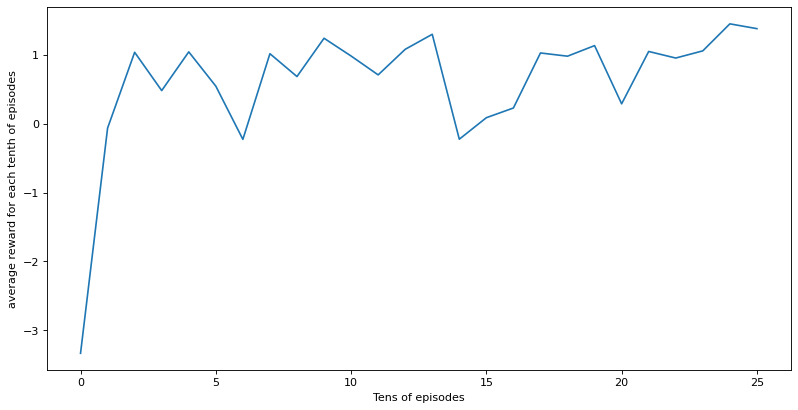

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)
plt.xlabel('Tens of episodes')
plt.ylabel('average reward for each tenth of episodes')
plt.plot(avg_rew_list)

# Reward per episode

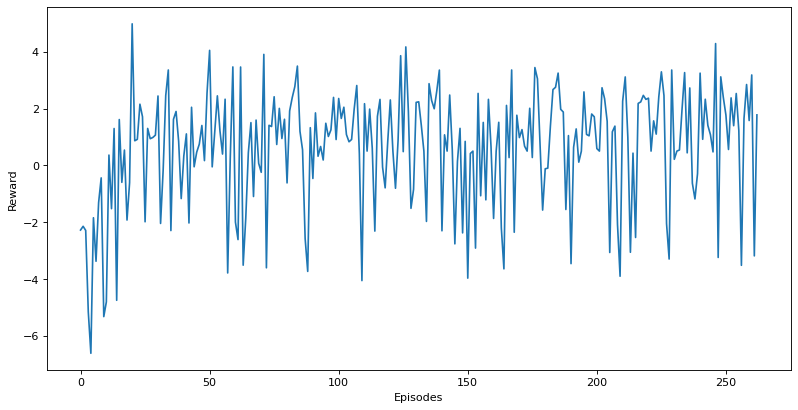

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(rew_list)

# Average Score for each tenth of episodes

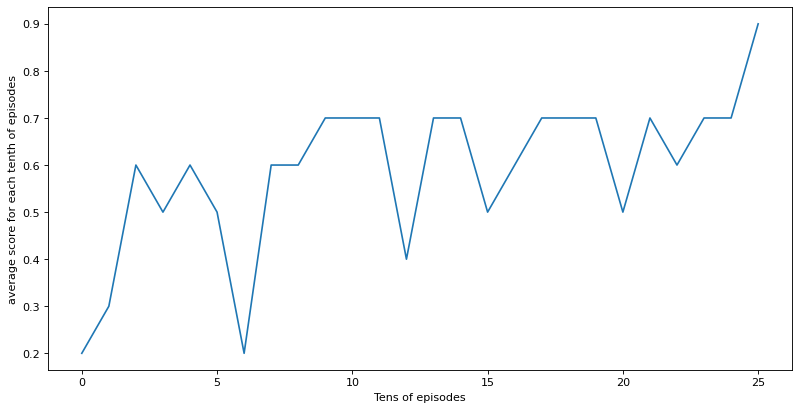

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Tens of episodes')
plt.ylabel('average score for each tenth of episodes')
plt.plot(avg_score_list)

# Score per Episode

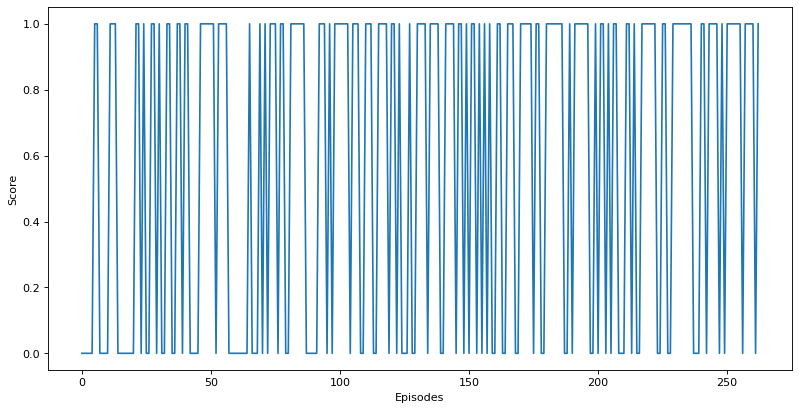

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.plot(score_list)

# Steps to Score for each episode

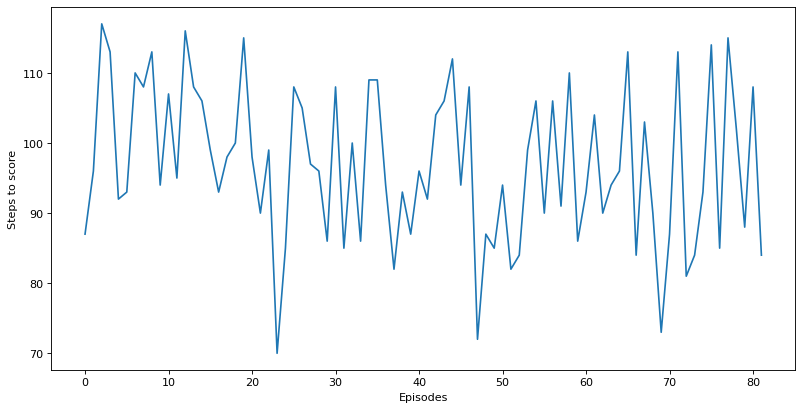

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Steps to score')
plt.plot(steps_to_goal)